Объединенный датасет доступен по [ссылке](https://drive.google.com/drive/folders/1jmxG2zfi-Fs3m2KrMGmjD347aYiT8YFM?usp=sharing).

Положить в папку data содержимое так, чтобы были следующие пути:  
* \$(ROOT_DIR)/data/merged-rtsd/...
* \$(ROOT_DIR)/data/gt.csv

> *gt_Set_NaN.csv - содержит тот же датасет, но значения колонки Set обнулено*

gt - датафрейм содержащий:  
* имена файлов - поле filename
* класс знака - поле sign_class
* флаг присутствия знака при работе с датасетом - IsPresent. Предполагается, что вместо удаления записи, будет устанавливатся этот флаг, включающий/не влючающий знак в выборку
* в какой набор включен знак - поле Set $\in$ $\{train, valid, test\}$

~~\# !gdown --id '1eKNfEuNQadRW1H4NOoMw5sdnyHV14ze0'
\# !unzip rtsd-r3.zip
\# !rm -rf rtsd-r3.zip~~

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Читаем данные, настраиваем дирректории. Инклудим *utils.ipynb*.

,filename,sign_class,is_present,set
0,000000.png,2_1,1,NaN
1,000001.png,2_1,1,NaN
2,000002.png,2_1,1,NaN
3,000003.png,2_1,1,NaN
4,000004.png,1_23,1,NaN
...,...,...,...,...
93649,093649.png,5_15_5,1,NaN
93650,093650.png,5_15_5,1,NaN
93651,093651.png,5_15_5,1,NaN
93652,093652.png,5_15_5,1,NaN


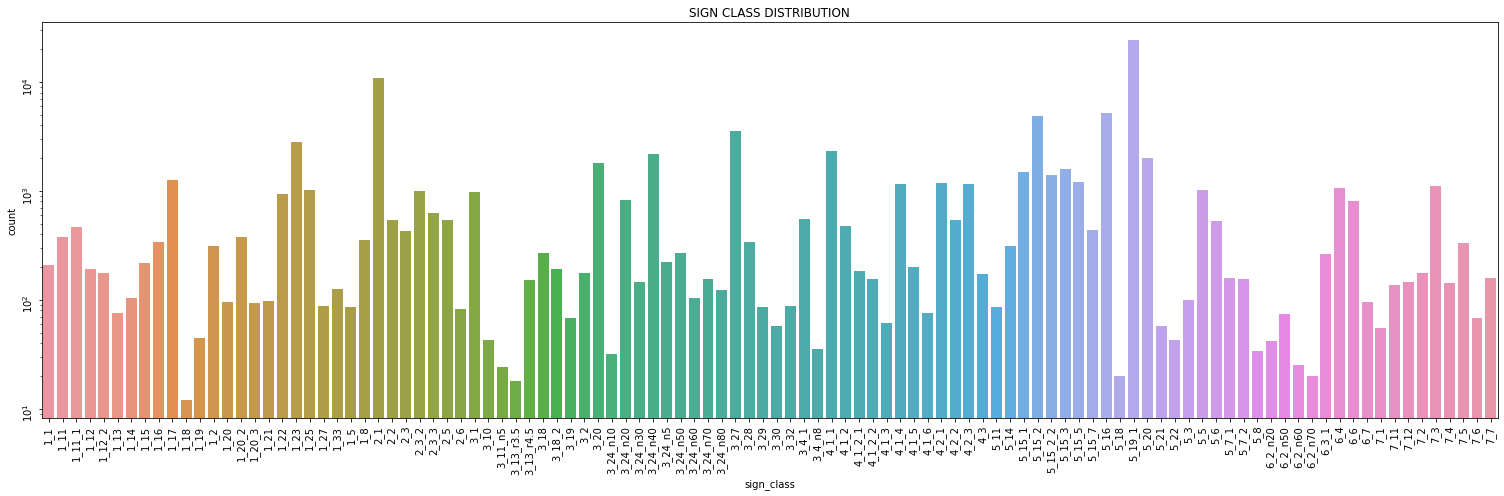

In [48]:
%run utils.ipynb
PROJECT_ROOT = pathlib.Path(os.path.join(os.curdir, os.pardir))
DATA_DIR = PROJECT_ROOT / 'data'

gt = pd.read_csv(DATA_DIR / 'gt.csv')
GT_SRC_LEN = len(gt.index)
display(gt)

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(21, 7))
ax.tick_params(labelrotation=90)

g = sns.countplot(x='sign_class', data=gt,  order=sorted(gt['sign_class'].value_counts().index.tolist()));
g.set_yscale("log")
ax.set_title('SIGN CLASS DISTRIBUTION')
plt.tight_layout()

Выкинем все неинтересующие классы.  

Progress: 93654/93654 (100.00%)
[!] These signs were not included: 
 {'3_22', '3_21', '3_24_n130', '1_31', '3_24_n110', '3_24_n90', '3_25', '3_24_n100', '6_3_2', '3_31', '3_24_n120', '3_23', '1_6', '2_4'}


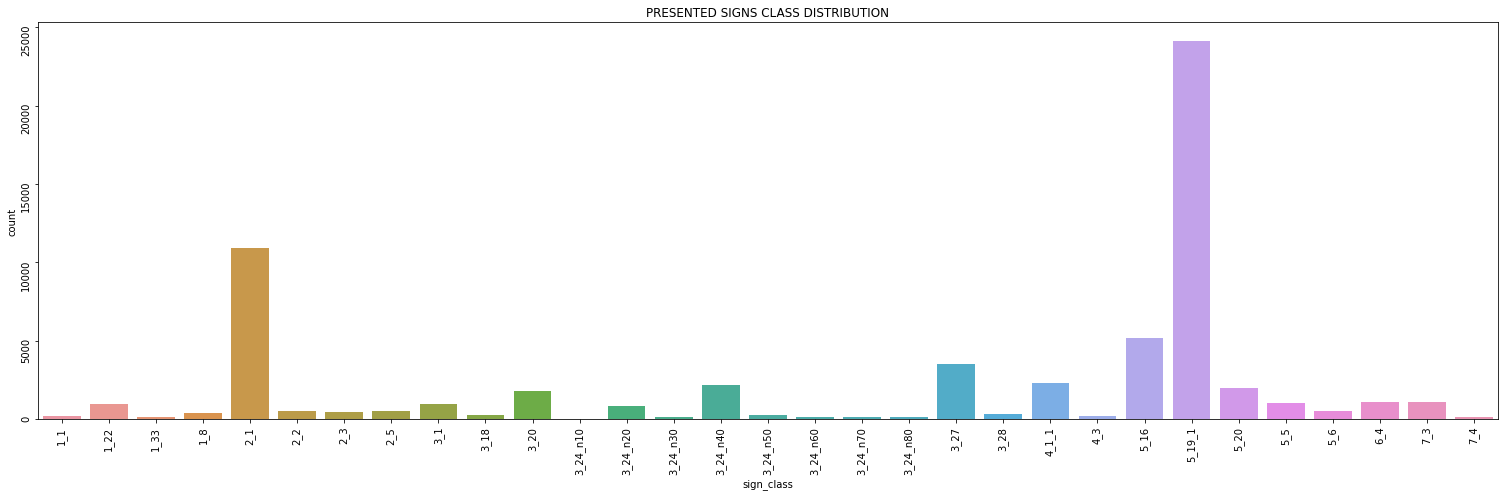

In [54]:
if len(np.unique(gt['set'])) == 1:
    CLASSES = [
        '1_1', '1_6', '1_8', '1_22', '1_31', '1_33', '2_1', '2_2', 
        # ~2_3_1
        '2_3', \
        # /~2_3_1
        '2_4', '2_5', '3_1', 
        # ~3_18_1
        '3_18', 
        # /~3_18_1
        '3_20', '3_21', '3_22', '3_23', \
        # all speed limits
        '3_24_n10', '3_24_n20', '3_24_n30', '3_24_n40', '3_24_n50', '3_24_n60', \
        '3_24_n70', '3_24_n80', '3_24_n90', '3_24_n100', '3_24_n110', '3_24_n120', '3_24_n130', \
        # /all speed limits
        '3_25', '3_27', '3_28', '3_31', '4_1_1', '4_3', '5_5', '5_6', '5_16', 
        '5_19_1',  
        #'5_19_2', \ ~ '5_19_1'
        '5_20', '6_3_2', '6_4', '7_3', '7_4'
    ]
    
    INCLUDED_CLASSES = set()
    IS_PRESENT_COLUMN_INDEX = gt.columns.get_loc("is_present")
    
    for row in gt.itertuples():

        if row.sign_class in CLASSES:          
            INCLUDED_CLASSES.add(row.sign_class)
        else:
            gt.iat[row.Index, IS_PRESENT_COLUMN_INDEX] = 0

        if (row.Index % 500 == 0) or (row.Index + 1 == GT_SRC_LEN):
            printProgressEnum(row.Index, GT_SRC_LEN)
            
    NOT_INCLUDED_SIGNS = set(CLASSES) - INCLUDED_CLASSES
    if NOT_INCLUDED_SIGNS:
        print('\n[!] These signs were not included: \n', NOT_INCLUDED_SIGNS)
        
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(21, 7))
ax.tick_params(labelrotation=90)

g = sns.countplot(x='sign_class', data=gt[gt['is_present']==1],  order=sorted(gt[gt['is_present']==1]['sign_class'].value_counts().index.tolist()));
ax.set_title('PRESENTED SIGNS CLASS DISTRIBUTION')
plt.tight_layout()

Сплитим по возможности в таком соотношении 20:20:60.  
Проблема - одного класса сильно больше чем другого.
Используем комбинацию методов, описанных [тут](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets?scriptVersionId=1756536&cellId=11): применим undersampling до среднего количества по группам. В недостающих группах докинем oversampling'ом.

In [224]:
gt_present = gt[gt['is_present']==1]
gt_present_grouped = gt_present.groupby('sign_class', axis=0)
# display(gt_present.head(50))
MEAN_BY_GROUPS = int(np.floor(gt_present_grouped.size().mean()))

SET_COLUMN_INDEX = gt.columns.get_loc("set")

for key, items in gt_present_grouped.groups.items():
    # print(items)
    items = list(items)     # явно приведем к списку для душевного спокойствия
    random.shuffle(items)   # перемешаем

    # print(key)
    
    if len(items) > MEAN_BY_GROUPS:
        # выбираем рандомные значения из этой группы в колличестве MEAN_BY_GROUPS*0.6 для train
        # MEAN_BY_GROUPS*0.2 для valid, остальное кинем в test
        # print(int(MEAN_BY_GROUPS*0.8))
        TEMP_ITEMS_INCLUDED = items[0:MEAN_BY_GROUPS]
        TEMP_ITEMS_EXCLUDED = items[MEAN_BY_GROUPS::]
        TRAIN_GROUP, VALID_GROUP, TEST_GPOUP = np.split(TEMP_ITEMS_INCLUDED, [int(len(TEMP_ITEMS_INCLUDED)*0.6), int(len(TEMP_ITEMS_INCLUDED)*0.8)])
        TEST_GPOUP = np.append(TEST_GPOUP, TEMP_ITEMS_EXCLUDED)
        #if key == '3_24_n40':
        #    print('TRAIN', sorted(TRAIN_GROUP), '\nVALID', sorted(VALID_GROUP), '\nTEST', sorted(TEST_GPOUP))
        #    # print('t', len(TRAIN_GROUP), 'v', len(VALID_GROUP), 't', len(TEST_GPOUP))
    else:
        TRAIN_GROUP, VALID_GROUP, TEST_GPOUP = np.split(items, [int(len(items)*0.6), int(len(items)*0.8)])
        # print('t', len(TRAIN_GROUP), 'v', len(VALID_GROUP), 't', len(TEST_GPOUP), '\n')
        # print('t', TRAIN_GROUP, 'v', VALID_GROUP, 't', TEST_GPOUP, '\n')
        
    gt.iloc[TRAIN_GROUP, SET_COLUMN_INDEX] = 'train'
    gt.iloc[VALID_GROUP, SET_COLUMN_INDEX] = 'valid'
    gt.iloc[TEST_GPOUP, SET_COLUMN_INDEX] = 'test'
    
# display(gt_present.head(50))
print('total ~NaN values in [set]:',gt['set'].value_counts().sum())
print('total [is_present]==1:', len(gt[gt['is_present']==1].index))
assert len(gt[gt['is_present']==1].index) == gt['set'].value_counts().sum()


total ~NaN values in [set]: 62456
total [is_present]==1: 62456


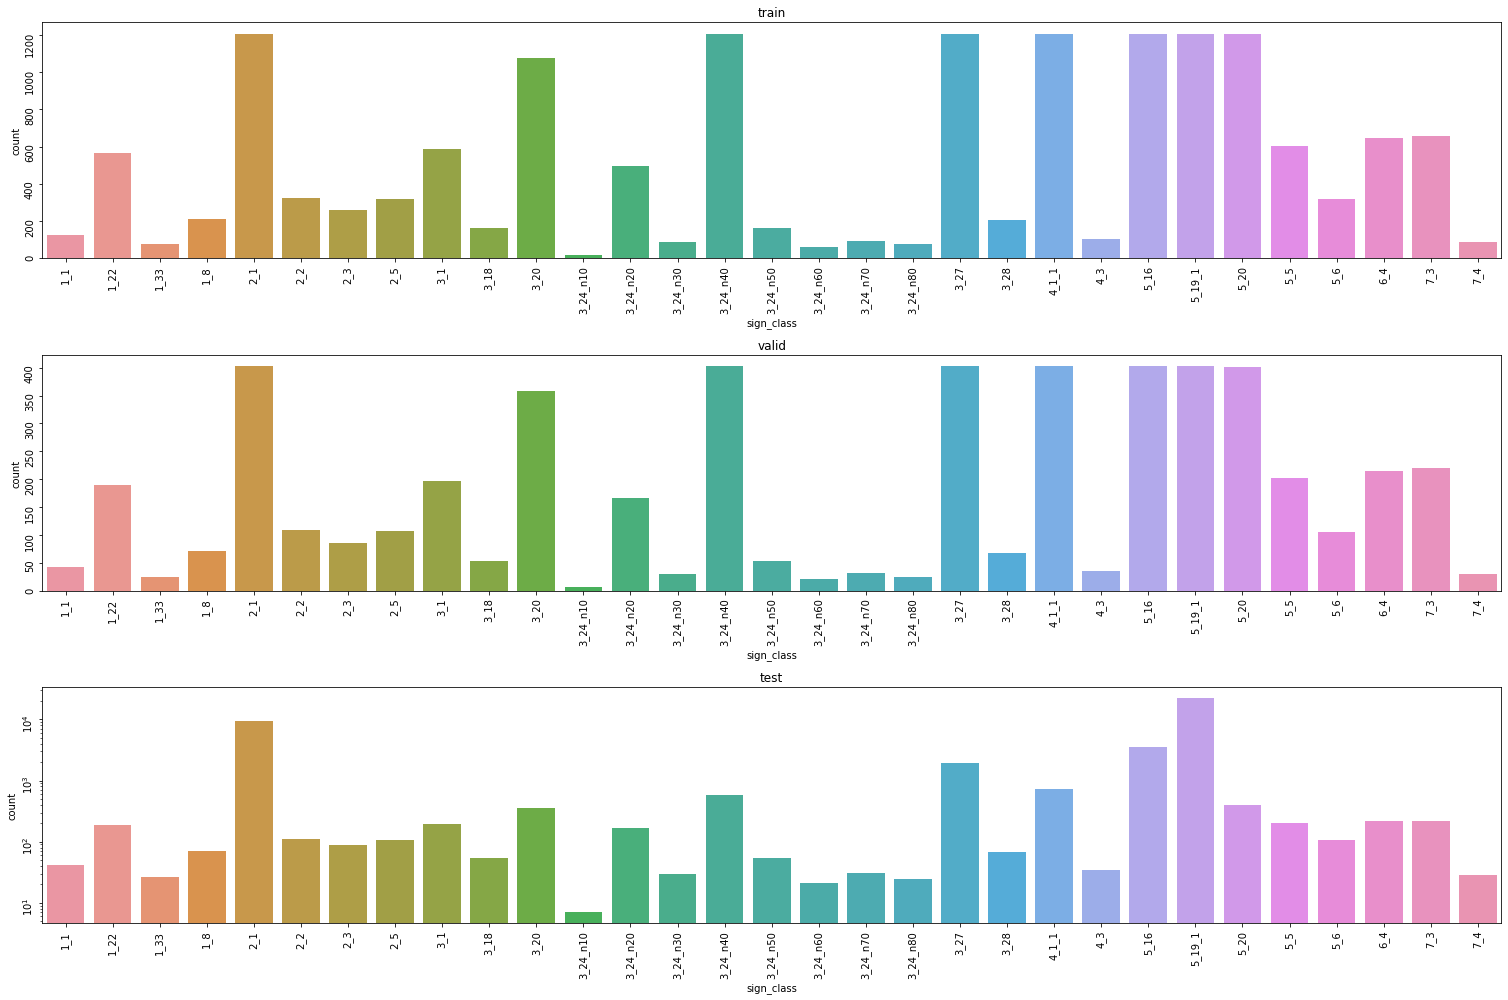

In [231]:
_, ax = plt.subplots(nrows=3, ncols=1, figsize=(21, 14))


LABELS = ['train', 'valid', 'test']
for i in range(len(LABELS)):
    g = sns.countplot(x='sign_class', data=gt[gt['set']==LABELS[i]],  ax=ax[i], order=sorted(gt[gt['is_present']==1]['sign_class'].value_counts().index.tolist()));
    ax[i].tick_params(labelrotation=90)
    ax[i].set_title(LABELS[i])
    plt.tight_layout()
    
ax[2].set_yscale("log")

In [218]:
pd.set_option('display.max_rows', None)
display(gt.groupby(['sign_class']).count())

pd.set_option('display.max_rows', 50)

,filename,is_present,set
sign_class,,,
1_1,208,208,208
1_11,380,380,0
1_11_1,467,467,0
1_12,191,191,0
1_12_2,175,175,0
1_13,75,75,0
1_14,104,104,0
1_15,216,216,0
1_16,341,341,0


In [194]:
gt[gt['sign_class']=='3_24_n40']['set'].describe()

count     1352
unique       1
top       test
freq      1352
Name: set, dtype: object

Объеденим тест и трейн, т.к. их "мощности" (количество классов знаков) не равны.

In [13]:
merged_test_train = ROOT_DIR / 'ALL'
if (merged_test_train.exists()):
  shutil.rmtree(merged_test_train)

merged_test_train.mkdir(parents=True, exist_ok=True)

for filename in train_dir.iterdir():
  shutil.copy(filename, merged_test_train)

def incrementFile(filename_src, val=1):
    ext = str(filename_src).split('.')[-1]
    filename = str(filename_src).split('.')[-2]
    src_str_len = len(filename)
    filename_int = int(filename) + val
    filename = str(filename_int)
    
    while (len(filename) < src_str_len):
        filename = '0' + filename

    return filename + '.' + ext

last_filename = sorted(os.listdir(merged_test_train))[-1]
inc_val = int(last_filename.split('.')[-2]) + 1 # coz starts with 0


for filename in test_dir.iterdir():
  
  target_path = merged_test_train / incrementFile(filename.name, inc_val)
  print(filename, '->', target_path)
  shutil.copy(filename, target_path)

gt_test_copy = gt_test.copy()
for index, row in gt_test_copy.iterrows():
  # print(row)
  target_filename = incrementFile(row['filename'], inc_val)
  # print(row['filename'], '->', target_filename)

  gt_test_copy.loc[index, 'filename'] = incrementFile(row['filename'], inc_val)

gt = pd.concat([gt_train, gt_test_copy], ignore_index=True)
gt['Set'] = pd.Series([None for x in range(len(gt.index))])

del gt_test, gt_train, gt_test_copy

Streaming output truncated to the last 5000 lines.
rtsd-r3/data/test/020098.png -> rtsd-r3/data/ALL/090785.png
rtsd-r3/data/test/020252.png -> rtsd-r3/data/ALL/090939.png
rtsd-r3/data/test/005090.png -> rtsd-r3/data/ALL/075777.png
rtsd-r3/data/test/022187.png -> rtsd-r3/data/ALL/092874.png
rtsd-r3/data/test/015713.png -> rtsd-r3/data/ALL/086400.png
rtsd-r3/data/test/019030.png -> rtsd-r3/data/ALL/089717.png
rtsd-r3/data/test/018849.png -> rtsd-r3/data/ALL/089536.png
rtsd-r3/data/test/022498.png -> rtsd-r3/data/ALL/093185.png
rtsd-r3/data/test/012638.png -> rtsd-r3/data/ALL/083325.png
rtsd-r3/data/test/013841.png -> rtsd-r3/data/ALL/084528.png
rtsd-r3/data/test/000027.png -> rtsd-r3/data/ALL/070714.png
rtsd-r3/data/test/020294.png -> rtsd-r3/data/ALL/090981.png
rtsd-r3/data/test/022895.png -> rtsd-r3/data/ALL/093582.png
rtsd-r3/data/test/004961.png -> rtsd-r3/data/ALL/075648.png
rtsd-r3/data/test/021385.png -> rtsd-r3/data/ALL/092072.png
rtsd-r3/data/test/013808.png -> rtsd-r3/data/ALL/

In [20]:
gt.to_csv('gt.csv')

In [ ]:
!zip -r /content/merged.zip /content/rtsd-r3/data/ALL

In [ ]:
from google.colab import files
files.download("/content/merged.zip")

In [8]:
gt = pd.concat([gt_train, gt_test_copy])
gt['Set'] = pd.Series([None for x in range(len(gt.index))])

NameError: ignored

In [ ]:
gt_test_copy = gt_test.copy()
for index, row in gt_test_copy.iterrows():
  # print(row)
  target_filename = incrementFile(row['filename'], inc_val)
  print(row['filename'], '->', target_filename)

  gt_test_copy.loc[index, 'filename'] = incrementFile(row['filename'], inc_val)

In [ ]:
display(gt_test)
display(gt_train)
print(inc_val)

In [ ]:
!ls rtsd-r3/data/ALL